# Section 1 image processing

*   Binary Images
*   Angle rotate





In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform

def rotate_image_mine(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def rotate_image(image, angle):
    return skimage.transform.rotate(image, angle)

def find_best_two_rotation_angles(image, angle_increment=1, max_angle=60):
    best_angle11 = 0
    best_angle22 = 0
    highest_max_value1 = -np.inf
    highest_max_value2 = -np.inf

    angles = range(-max_angle, max_angle, angle_increment)

    for angle in angles:
        rotated_image = rotate_image(image, angle)
        vertical_hist = np.sum(rotated_image, axis=1, keepdims=True) / 100
        max_value = np.max(vertical_hist)

        if max_value > highest_max_value1:
            highest_max_value2 = highest_max_value1
            best_angle22 = best_angle11

            highest_max_value1 = max_value
            best_angle11 = angle
        elif max_value > highest_max_value2:
            highest_max_value2 = max_value
            best_angle22 = angle



    return (best_angle11, highest_max_value1), (best_angle22, highest_max_value2)

In [3]:
import cv2
def preprocess_image(image):
    # Read the image

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive thresholding
    thresh11 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 5, 5)

    return thresh11



In [73]:
import cv2

path = "./runs/detect/exp32/crops/English-plate/foo.jpg"

image = cv2.imread(path)
(best_angle, max_val), _ = find_best_two_rotation_angles(image)

image = rotate_image_mine(image, best_angle)
cv2.imwrite("./raw_saved.jpg", image)

thresh = preprocess_image(image)
cv2.imwrite("./saved.jpg", thresh)



True

In [9]:
def resize_image(image_path, scale_factor, interpolation=cv2.INTER_CUBIC):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Get the original dimensions
    original_size = (image.shape[1], image.shape[0])  # (width, height)

    # Calculate the new dimensions
    new_size = (int(original_size[0] * scale_factor), int(original_size[1] * scale_factor))

    # Resize the image
    resized_image = cv2.resize(image, new_size, interpolation=interpolation)

    return resized_image
#scale_factor = 2  # Double the size of the image
# Example usage
#paths=os.listdir("/content/images_rotated")
#for path in paths:
#  if path.endswith(".jpg"):
#    resized_image = resize_image("/content/images_rotated/"+path, scale_factor, interpolation=cv2.INTER_LANCZOS4)
#    output_image_path = '/content/images_resized/RESIZED_'+path.split('/')[-1]
#    cv2.imwrite(output_image_path, resized_image)


In [74]:
import cv2

cv2.imwrite("saved.jpg", resize_image("saved.jpg", 2))

True

In [75]:
kernel = np.ones((3, 3), np.uint8)

# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(thresh, kernel, iterations=1)
img_erosion
img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
img_dilation
cv2.imwrite("saved.jpg", thresh)

True

In [21]:
import os

def calculate_height_width_ratio(path):
    ratios = {}
    for label in os.listdir(os.path.join(path, "train", "labels")):
        with open(os.path.join(path, "train", "labels", label), "r") as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split(" ")
                if len(line) != 5:
                    continue
                width, height = float(line[3]), float(line[4])
                class_id = int(line[0])
                if class_id in ratios.keys():
                    ratios[class_id].append(height/width)
                else:
                    ratios[class_id] = [height/width]
    return ratios

ratios = calculate_height_width_ratio("./yolo_reduced_dataset")

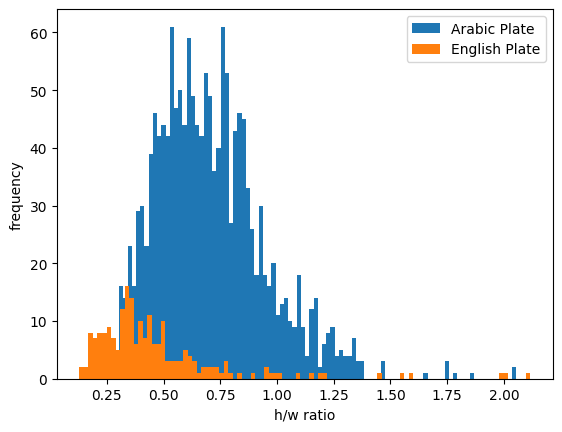

In [22]:
import matplotlib.pyplot as plt

plt.hist(ratios[0], bins=100, label="Arabic Plate")
plt.hist(ratios[1], bins=100, label="English Plate")
plt.xlabel("h/w ratio")
plt.ylabel("frequency")
plt.legend()

plt.show()

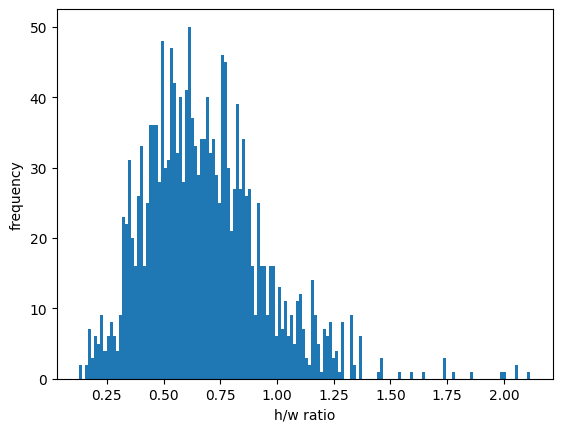

In [23]:
import matplotlib.pyplot as plt

all_data = ratios[0] + ratios[1]
plt.hist(all_data, bins=150)
plt.xlabel("h/w ratio")
plt.ylabel("frequency")
plt.show()

In [24]:
import statistics

def get_stats(data):
    "Returns the harmonic mean, mean, and standard deviation of a given dataset"
    return statistics.harmonic_mean(data), statistics.mean(data), statistics.stdev(data)

with open("bboxes_data.csv", "w") as f:
    f.write("Plate type, harmonic mean, mean, standard deviation\n")
    arabic_hm, arabic_mean, arabic_stdev = get_stats(ratios[0])
    f.write(f"Arabic Plate, {arabic_hm}, {arabic_mean}, {arabic_stdev}\n")
    english_hm, english_mean, english_stdev = get_stats(ratios[1])
    f.write(f"English Plate, {english_hm}, {english_mean}, {english_stdev}\n")
    hm, mean, stdev = get_stats(all_data)
    f.write(f"Total, {hm}, {mean}, {stdev}")

In [76]:
# prompt: perform canny edge on the roatet image

edges = cv2.Canny(thresh, 50, 100)

cv2.imwrite('canny_edges.png', edges)
edges

array([[  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       ...,
       [  0, 255,   0, ..., 255, 255,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0]], dtype=uint8)

In [18]:
import cv2
import numpy as np
def visualize_canny_edges(image_path, low_threshold=50, high_threshold=100):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detector
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)

    # Display the original and edge-detected images side by side
    combined_image = np.hstack((gray_image, edges))

    # Add text labels to differentiate between original and edge-detected images
    cv2.putText(combined_image, 'Original', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(combined_image, 'Edges', (gray_image.shape[1] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the combined image
    # cv2_imshow(edges)
    cv2.imwrite(f'./{image_path.split("/")[-1][:-3]}png', edges)

# Example usage
#image_path = "saved.jpg"  # Replace with your image path
#visualize_canny_edges(image_path)

In [27]:
import cv2
import csv

def adjust_contour(image, x, y, w, h):
    """
    Takes image with its best fit contour as input. Modifies contour to ensure whole license plate is captured.
    """
    assert h != 0 and w != 0, "Invalid box dimensions"
    image_height, image_width, _ = image.shape
    print(image.shape)
    

    #LP width should be at least 80% of bounding box width
    w = round(max(w, 0.8 * image_width))

    stat_file = "./image processing/bboxes_data.csv"

    #Extract average LP H/W ratio
    with open(stat_file, "r") as f:
         reader = csv.reader(f)
         line = None
         for row in reader:
              if row[0] == "English Plate":
                   line = row
    _, harmonic_mean, mean, stdev = line
    harmonic_mean = float(harmonic_mean)
    mean = float(mean)
    stdev = float(stdev) 
    print(mean, stdev)
    
    #Ensure consistency with average ratio
    hw_ratio = h / w
    print(hw_ratio)
    if hw_ratio < mean - stdev or hw_ratio> mean + 2 * stdev:
            h = round(h * (mean / hw_ratio))
    
    image_center_x, image_center_y = image_width // 2, image_height // 2
    print(image_center_x, image_center_y)
    center_x, center_y = x + w // 2, y + h//2
    print(center_x, center_y)
    if center_x < image_center_x - 0.05 * image_width or center_x > image_center_x + 0.05 * image_width:
        #If LP is not centered, move it to center of image
        print("Not x-centered")
        x = image_center_x - w//2
    if center_y < image_center_y - 0.1 * image_height or center_y > image_center_y + 0.1 * image_height:
        print("Not y-centered")
        y = image_center_y - h//2


    return x, y, w, h
#Example Usage
#image = cv2.imread("./raw_saved.jpg")
#adjust_contour(image, 67, 26, 9, 14)

In [33]:
import cv2
import numpy as np

def find_license_plate_boxes(edge_image, image_path):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to hold the largest contours by area and perimeter
    largest_contour_area = None
    largest_contour_perimeter = None
    largest_area = 0
    largest_perimeter = 0

    # Loop through all detected contours
    for contour in contours:
        image = cv2.imread(image_path)
        cv2.drawContours(image, contour, -1, (0, 255, 0), 2)

        # Display the original image with contours
        # cv2_imshow(image)
        # Calculate the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)
        # Approximate the contour
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        # print(len(approx))
        # Consider contours that have between 4 and 5 corners (approximate to a rectangle)
        if 2 <= len(approx) <= 17:

            area = cv2.contourArea(contour)

            # Update if the current contour has the largest area
            # print(area)
            # print(perimeter)
            # Update if the current contour has the largest perimeter
            if perimeter > largest_perimeter:
                rect_perimeter = cv2.minAreaRect(contour)
                box_perimeter = cv2.boxPoints(rect_perimeter)
                box_perimeter = np.int0(box_perimeter)

                largest_contour_perimeter = contour
                largest_perimeter = perimeter

            # Update if the current contour has the largest area
            if area > largest_area:
                rect_area = cv2.minAreaRect(contour)
                box_area = cv2.boxPoints(rect_area)
                box_area = np.int0(box_area)

                largest_contour_area = contour
                largest_area = area

    # Check if any contours were found
    if largest_contour_area is not None and largest_contour_perimeter is not None:
        # Get bounding box coordinates for the largest area
        x_area, y_area, w_area, h_area = cv2.boundingRect(largest_contour_area)
        print(x_area, y_area, w_area, h_area)
        # Adjust box to optimize fitting
        #if w_area * h_area < 0.7 * edge_image.shape[0] * edge_image.shape[1]:
        #    x_area, y_area, w_area, h_area = adjust_contour(image, x_area, y_area, w_area, h_area)
        
        # Get bounding box coordinates for the largest perimeter
        x_perimeter, y_perimeter, w_perimeter, h_perimeter = cv2.boundingRect(largest_contour_perimeter)
        # Adjust box to optimize fitting
        #if w_perimeter * h_perimeter < 0.7 * edge_image.shape[0] * edge_image.shape[1]:
        #    x_perimeter, y_perimeter, w_perimeter, h_perimeter = adjust_contour(image, x_perimeter, y_perimeter, w_perimeter, h_perimeter)

        # Determine which box has the largest area between the two
        box_area1 = w_area * h_area
        box_area2 = w_perimeter * h_perimeter

        if box_area1 > box_area2:
            return (x_area, y_area, w_area, h_area), largest_contour_area
        else:
            return (x_perimeter, y_perimeter, w_perimeter, h_perimeter), largest_contour_perimeter
    else:
        raise ValueError("No suitable license plate contours detected.")

def visualize_license_plate_boxes(image_path, edge_image):
    # Load the original image

    image = cv2.imread(image_path)
    # Find the bounding boxes of the license plate
    bounding_box, contour = find_license_plate_boxes(edge_image,image_path)
    x, y, w, h = bounding_box

    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cropped_image = image[y:y+h, x:x+w]

    # Save the cropped image
    cropped_image_path = f"./unboxes/{image_path.split('/')[-1]}"
    print(cropped_image_path)
    cv2.imwrite(cropped_image_path, cropped_image)
    cv2.imwrite("./not_cropped.jpg", image)
    # Draw the contour

    # cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)
    # Display the result

#edge_image = cv2.imread("./canny_edges.png", cv2.IMREAD_GRAYSCALE)
#visualize_license_plate_boxes("./raw_saved.jpg", edge_image)
# Example usage
#paths=os.listdir('/content/images_rotated')
#for path in paths:
#  path= "/content/images_rotated/"+path
#  print(path)
#  visualize_canny_edges(path)
#  edge_image_path = '/content/canny_edges.png'  # Replace with the path to your edge-detected image
#  image_path = path  # Replace with the path to your original image
#  edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)
#  visualize_license_plate_boxes(image_path, edge_image)


In [34]:
import os

for path in os.listdir("./runs/detect/exp2/crops/English-plate"):
    image = cv2.imread("./runs/detect/exp2/crops/English-plate/" +path)
    (best_angle, max_val), _ = find_best_two_rotation_angles(image)

    image = rotate_image_mine(image, best_angle)
    cv2.imwrite(f"./rotated_images/{path}", image)

    thresh = preprocess_image(image)
    kernel = np.ones((3, 3), np.uint8)

    img_erosion = cv2.erode(thresh, kernel, iterations=1)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    cv2.imwrite(f"./rotated_images/processed_{path}", thresh)
    edges = cv2.Canny(thresh, 50, 100)

    cv2.imwrite(f'./canny/{path[:-3]}png', edges)
    visualize_license_plate_boxes("./runs/detect/exp2/crops/English-plate/"+ path, edges)
    

C:\Users\User\AppData\Local\Temp\ipykernel_17424\4287882997.py:38: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_perimeter = np.int0(box_perimeter)
C:\Users\User\AppData\Local\Temp\ipykernel_17424\4287882997.py:47: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_area = np.int0(box_area)


5 13 14 4
(78, 120, 3)
0.46709354076874443 0.30836991633216365
0.041666666666666664
60 39
53 35
Not x-centered
(78, 120, 3)
0.46709354076874443 0.30836991633216365
0.3300970873786408
60 39
56 34
./boxes/13_jpg.rf.1665f839ba5e9b114f2e32a62ddd2005.jpg
114 28 16 36
(97, 179, 3)
0.46709354076874443 0.30836991633216365
0.2517482517482518
89 48
185 46
Not x-centered
(97, 179, 3)
0.46709354076874443 0.30836991633216365
0.3706293706293706
89 48
95 44
./boxes/14_jpg.rf.aaa3db98a8f0e3c867c91b2ec427bc8c.jpg
38 0 10 9
(45, 86, 3)
0.46709354076874443 0.30836991633216365
0.13043478260869565
43 22
72 16
Not x-centered
Not y-centered
(45, 86, 3)
0.46709354076874443 0.30836991633216365
0.20512820512820512
43 22
47 34
Not y-centered
./boxes/14_jpg.rf.f1c081d395119dc3a3b80a247afbffc1.jpg
59 23 5 14
(64, 95, 3)
0.46709354076874443 0.30836991633216365
0.18421052631578946
47 32
97 30
Not x-centered
(64, 95, 3)
0.46709354076874443 0.30836991633216365
0.4375
47 32
47 31
./boxes/15_png.rf.0976cfbb500a2152e1a3f

# Tesseract

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,982 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
! pip install Pillow
! pip install pytesseract

In [ ]:
# Load languages and scripts
!git clone --recurse-submodules https://github.com/tesseract-ocr/tessdata_fast.git 2> /dev/null || (cd tessdata_fast; git pull)
!cp tessdata_fast/*.traineddata /usr/share/tesseract-ocr/4.00/tessdata/
!cp -r tessdata_fast/script /usr/share/tesseract-ocr/4.00/tessdata/

Submodule path 'tessconfigs': checked out '3decf1c8252ba6dbeef0bf908f4b0aab7f18d113'


In [ ]:
# import the necessary packages
from pytesseract import Output
import pytesseract
import argparse
import imutils
import cv2
from PIL import Image
# load the input image, convert it from BGR to RGB channel ordering,
# and use Tesseract to determine the text orientation
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)
image = cv2.imread("/content/Images/018_jpg.rf.c9d875cc92b9d4f9212f9955b988e299.jpg")
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pytesseract.image_to_osd(image, output_type='dict')
print(results)


TesseractError: (1, 'Tesseract Open Source OCR Engine v4.1.1 with Leptonica Warning: Invalid resolution 0 dpi. Using 70 instead. Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.')

# Deskew

In [ ]:
pip install deskew

In [ ]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate

from deskew import determine_skew

image = io.imread('/content/pic1.jpg')
grayscale = rgb2gray(image)
angle = determine_skew(grayscale)
rotated = rotate(image, angle, resize=True) * 255
io.imsave('output.png', rotated.astype(np.uint8))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
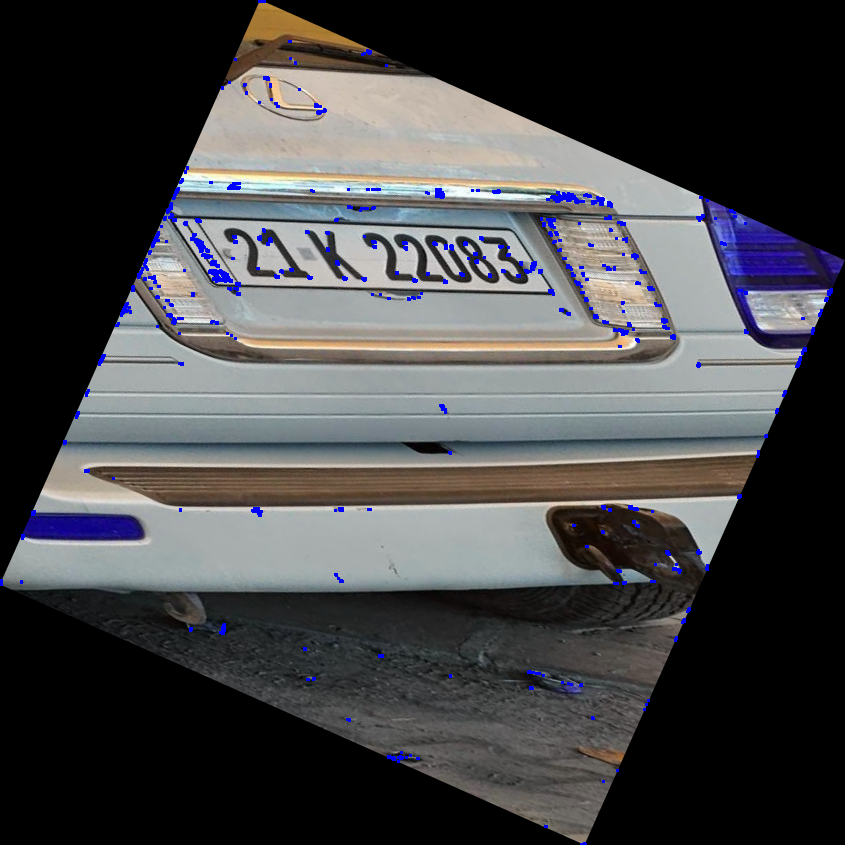

In [ ]:
import numpy as np
import cv2 as cv

filename = 'output.png'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

img


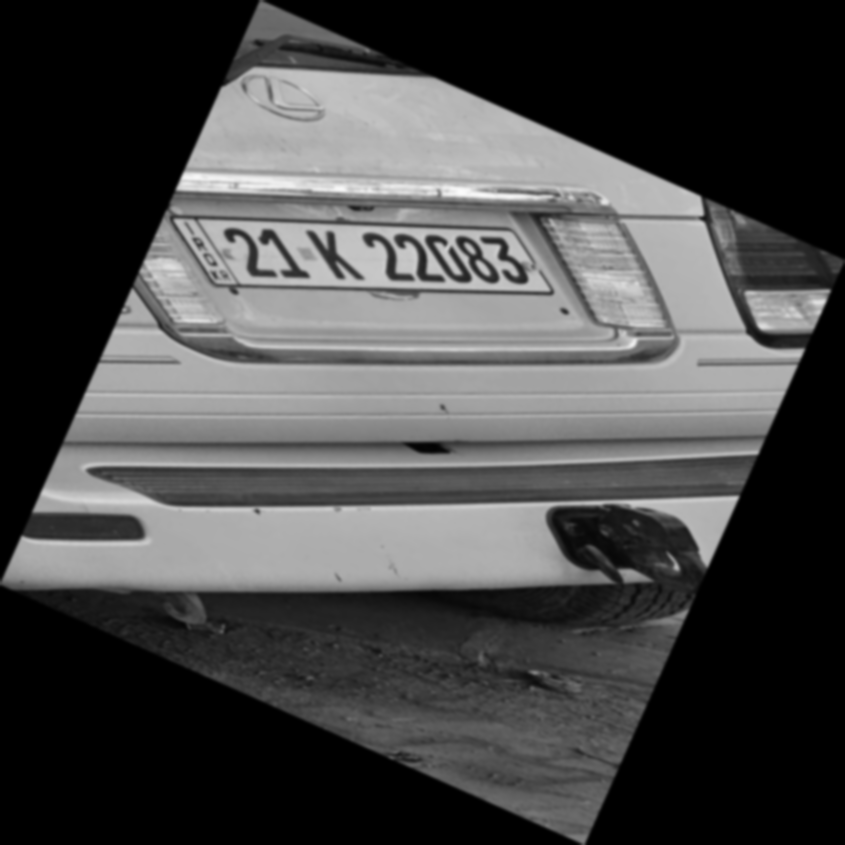

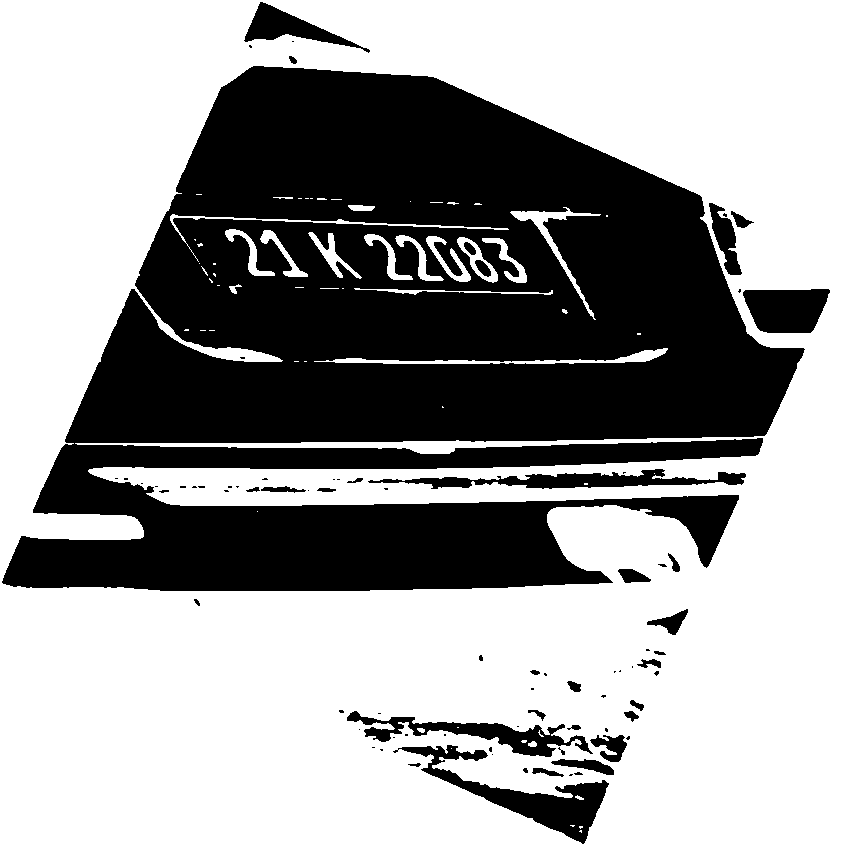

46


NameError: name 'totalLabels' is not defined

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Loading the image
img = cv2.imread('./output.png')

# preprocess the image
gray_img = cv2.cvtColor(img ,
						cv2.COLOR_BGR2GRAY)

# Applying 7x7 Gaussian Blur
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)
cv2_imshow(blurred)
# Applying threshold
threshold = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(threshold)
# Apply the Component analysis function
output = cv2.connectedComponentsWithStats(
	img_dilation, 100, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
print(numLabels)

# Initialize a new image to
# store all the output components
output = np.zeros(gray_img.shape, dtype="uint8")

# Loop through each component
for i in range(1, totalLabels):

	# Area of the component
	area = values[i, cv2.CC_STAT_AREA]

	if (area > 140) and (area < 400):
		# Create a new image for bounding boxes
		new_img=img.copy()

		# Now extract the coordinate points
		x1 = values[i, cv2.CC_STAT_LEFT]
		y1 = values[i, cv2.CC_STAT_TOP]
		w = values[i, cv2.CC_STAT_WIDTH]
		h = values[i, cv2.CC_STAT_HEIGHT]

		# Coordinate of the bounding box
		pt1 = (x1, y1)
		pt2 = (x1+ w, y1+ h)
		(X, Y) = centroid[i]

		# Bounding boxes for each component
		cv2.rectangle(new_img,pt1,pt2,
					(0, 255, 0), 3)
		cv2.circle(new_img, (int(X),
							int(Y)),
				4, (0, 0, 255), -1)

		# Create a new array to show individual component
		component = np.zeros(gray_img.shape, dtype="uint8")
		componentMask = (label_ids == i).astype("uint8") * 255

		# Apply the mask using the bitwise operator
		component = cv2.bitwise_or(component,componentMask)
		output = cv2.bitwise_or(output, componentMask)

		# Show the final images
		cv2_imshow( new_img)
		cv2_imshow( component)
		cv2_imshow( output)
		cv2.waitKey(0)


# edges

In [ ]:
# # prompt: give the function to visulizer the dtecetc corners visualize_corners(image_path, corners)

# def visualize_corners(image, corners):
#     # Load the image


#     # Draw the corners on the image
#     for corner in corners:
#         cv2.circle(image, tuple(corner), 5, (0, 255, 0), -1)

#     # Show the image with corners
#     plt.imshow(image)
#     plt.title("Detected License Plate Corners")
#     plt.show()
# visualize_corners(rotate, corners)

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# def detect_license_plate_corners(image):
#     # Load the image

#     gray = image
#     # Edge detection
#     edges = cv2.Canny(gray, 50, 200)

#     # Find contours
#     contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#     # Filter contours to find potential license plates
#     license_plate_contour = None
#     for contour in contours:
#         epsilon = 0.05 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)
#         if len(approx) == 4:  # Check for quadrilateral
#             license_plate_contour = approx
#             break

#     if license_plate_contour is None:
#         raise ValueError("No license plate contour detected.")

#     # Extract corner points
#     corners = license_plate_contour.reshape(4, 2)

#     return corners

# # Example usage
# image_path = '/content/Images/70-1-_jpg.rf.d441ae9ef94c029ffcbfe74b95b8f4de.jpg'
# image = cv2.imread(image_path)

# corners = detect_license_plate_corners(image)

# print("Detected corners:", corners)
# visualize_corners(rotate, corners)

In [65]:
import cv2

edge_image = cv2.imread("canny_edges.png", cv2.IMREAD_GRAYSCALE)
visualize_license_plate_boxes("saved.jpg", edge_image)

./cropped_image.jpg


C:\Users\User\AppData\Local\Temp\ipykernel_13036\872596686.py:38: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_perimeter = np.int0(box_perimeter)
C:\Users\User\AppData\Local\Temp\ipykernel_13036\872596686.py:47: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_area = np.int0(box_area)


In [2]:
!pip install paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.0/780.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 49.9 MB/s e

In [2]:
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00


In [3]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
img_path = '/content/5_jpg.rf.08e989a458736c430ac8684895d3050f.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)


# draw result
from PIL import Image
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result.jpg')

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:14<00:00, 285kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:15<00:00, 658kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:12<00:00, 176kiB/s]

[2024/06/26 20:08:40] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

[2024/06/26 20:08:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04838132858276367
[2024/06/26 20:08:41] ppocr DEBUG: cls num  : 1, elapsed : 0.029791831970214844
[2024/06/26 20:08:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10642600059509277
[[[4.0, 3.0], [86.0, 3.0], [86.0, 20.0], [4.0, 20.0]], ('22375776', 0.8874877691268921)]


OSError: cannot open resource

In [ ]:
# prompt: download a file named x froim colab runtile to my local machine zip the folder before

from google.colab import files

# Get the file from the user

# Download the file

# Zip the folder
!zip -r folder.zip /content/images_cropped

# Download the zip file
files.download("folder.zip")


  adding: content/images_cropped/ (stored 0%)
  adding: content/images_cropped/70-1-_jpg.rf.d441ae9ef94c029ffcbfe74b95b8f4de.jpg (deflated 9%)
  adding: content/images_cropped/69-3-_jpg.rf.2bd0216bca0355f5de78929ab9e42ced.jpg (deflated 4%)
  adding: content/images_cropped/417364312_1068529891141645_6625828181421494034_n_jpg.rf.f3d71e0a025ad3d1237b0a7c137fb060.jpg (deflated 10%)
  adding: content/images_cropped/13_jpg.rf.1665f839ba5e9b114f2e32a62ddd2005.jpg (deflated 7%)
  adding: content/images_cropped/58_jpg.rf.0f7e465b5f8d3acd39e43dcadb31b7f0.jpg (deflated 4%)
  adding: content/images_cropped/66_jpg.rf.47032f2c1c7d2a1bb2cbd7b9176df200.jpg (deflated 5%)
  adding: content/images_cropped/428479596_2083530045364234_3401595779526985803_n_jpg.rf.e04cce7bf1401b66fa7418d2f531d39b.jpg (deflated 5%)
  adding: content/images_cropped/15_png.rf.0976cfbb500a2152e1a3fc0c1a4e5857.jpg (deflated 8%)
  adding: content/images_cropped/59_jpg.rf.5a62af5074f6f4d20136f24a27ed931a.jpg (deflated 5%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test on 1 photo

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def find_license_plate_boxes_old(edge_image, image_path):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to hold the largest contours by area and perimeter
    largest_contour_area = None
    largest_contour_perimeter = None
    largest_area = 0
    largest_perimeter = 0

    # Loop through all detected contours
    for contour in contours:
        image = cv2.imread(image_path)
        cv2.drawContours(image, contour, -1, (0, 255, 0), 2)

        # Display the original image with contours
        cv2_imshow(image)
        # Calculate the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)
        # Approximate the contour
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        print(len(approx))
        # Consider contours that have between 4 and 5 corners (approximate to a rectangle)
        if 2 <= len(approx) <= 17:

            area = cv2.contourArea(contour)

            # Update if the current contour has the largest area
            print(area)
            print(perimeter)
            # Update if the current contour has the largest perimeter
            if perimeter > largest_perimeter:
                rect_perimeter = cv2.minAreaRect(contour)
                box_perimeter = cv2.boxPoints(rect_perimeter)
                box_perimeter = np.int0(box_perimeter)

                largest_contour_perimeter = contour
                largest_perimeter = perimeter

            # Update if the current contour has the largest area
            if area > largest_area:
                rect_area = cv2.minAreaRect(contour)
                box_area = cv2.boxPoints(rect_area)
                box_area = np.int0(box_area)

                largest_contour_area = contour
                largest_area = area

    # Check if any contours were found
    if largest_contour_area is not None and largest_contour_perimeter is not None:
        # Get bounding box coordinates for the largest area
        x_area, y_area, w_area, h_area = cv2.boundingRect(largest_contour_area)
        # Get bounding box coordinates for the largest perimeter
        x_perimeter, y_perimeter, w_perimeter, h_perimeter = cv2.boundingRect(largest_contour_perimeter)

        # Determine which box has the largest area between the two
        box_area1 = w_area * h_area
        box_area2 = w_perimeter * h_perimeter

        if box_area1 > box_area2:
            return (x_area, y_area, w_area, h_area), largest_contour_area
        else:
            return (x_perimeter, y_perimeter, w_perimeter, h_perimeter), largest_contour_perimeter
    else:
        raise ValueError("No suitable license plate contours detected.")

def visualize_license_plate_boxes(image_path, edge_image):
    # Load the original image

    image = cv2.imread(image_path)
    # Find the bounding boxes of the license plate
    bounding_box, contour = find_license_plate_boxes(edge_image,image_path)
    x, y, w, h = bounding_box

    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Draw the contour

    cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)
    # Display the result
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Example usage
paths=os.listdir('/content/images_rotated')
for path in paths:
  path= "/content/images_rotated/13_jpg.rf.1665f839ba5e9b114f2e32a62ddd2005.jpg"
  print(path)
  visualize_canny_edges(path)
  edge_image_path = '/content/canny_edges.png'  # Replace with the path to your edge-detected image
  image_path = path  # Replace with the path to your original image
  edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)
  visualize_license_plate_boxes(image_path, edge_image)
  break

70-1-_jpg.rf.d441ae9ef94c029ffcbfe74b95b8f4de.jpg


<ipython-input-14-222639a38467>:20: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-14-222639a38467>:79: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.transform(np.array([box]), rotation_matrix)[0])


69-3-_jpg.rf.2bd0216bca0355f5de78929ab9e42ced.jpg


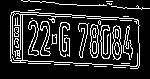

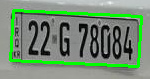

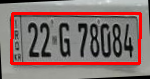

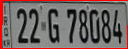

417364312_1068529891141645_6625828181421494034_n_jpg.rf.f3d71e0a025ad3d1237b0a7c137fb060.jpg


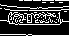

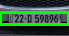

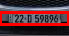

13_jpg.rf.1665f839ba5e9b114f2e32a62ddd2005.jpg


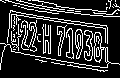

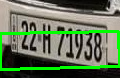

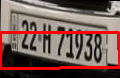

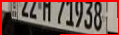

58_jpg.rf.0f7e465b5f8d3acd39e43dcadb31b7f0.jpg


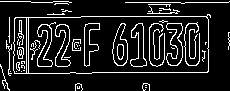

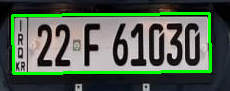

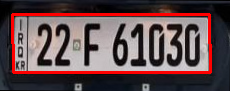

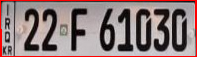

66_jpg.rf.47032f2c1c7d2a1bb2cbd7b9176df200.jpg


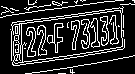

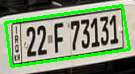

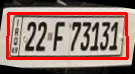

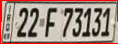

428479596_2083530045364234_3401595779526985803_n_jpg.rf.e04cce7bf1401b66fa7418d2f531d39b.jpg


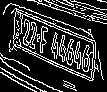

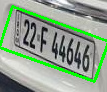

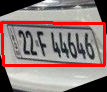

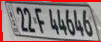

15_png.rf.0976cfbb500a2152e1a3fc0c1a4e5857.jpg


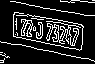

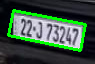

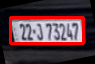

59_jpg.rf.5a62af5074f6f4d20136f24a27ed931a.jpg


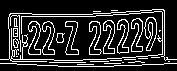

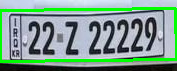

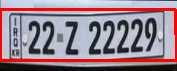

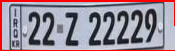

189_jpg.rf.b9d5b30ec71075a507f23d6622a1f7eb.jpg


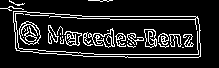

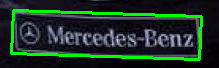

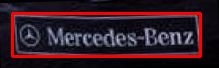

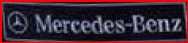

52_jpg.rf.b397e1748e6adf4dadcfdb061d72aaf2.jpg


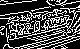

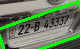

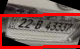

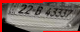

57_jpg.rf.4d70900ecf4c5af1e6db08e7fc1fc015.jpg


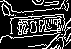

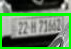

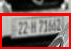

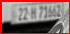

70-13-_jpg.rf.155d171cdc72c0ac0e035e1b926569a9.jpg


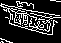

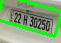

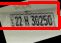

57_jpg.rf.4d70900ecf4c5af1e6db08e7fc1fc0152.jpg


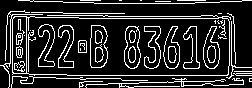

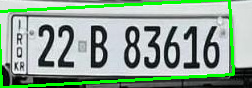

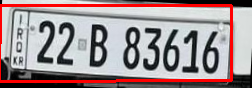

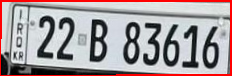

27_png.rf.b0b8716a131c0677226f471ab3678c72.jpg


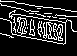

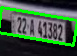

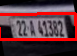

14_jpg.rf.f1c081d395119dc3a3b80a247afbffc1.jpg


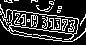

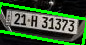

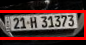

5_jpg.rf.08e989a458736c430ac8684895d3050f.jpg


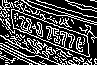

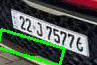

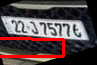

70-13-_jpg.rf.fa2aea14b2828cc01a9b67c6c3cea43a.jpg


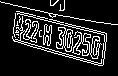

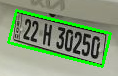

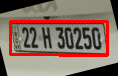

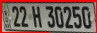

70-3-_jpg.rf.2a17adf768ca0f94b5838147ddcf6a7a.jpg


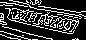

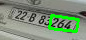

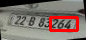

419420193_2608644655967002_1421768417040176403_n_jpg.rf.e39b11b7b14e404ebe939432f104b554.jpg


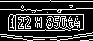

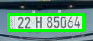

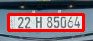

427649041_308812638842663_5019511625679107493_n_jpg.rf.9998e3a09980c149e92cd23bf3219022.jpg


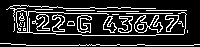

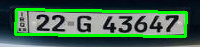

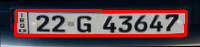

419173054_777935504164308_496264249723982035_n_jpg.rf.7fe782987e9a6766473a034b8eb1b156.jpg


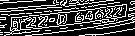

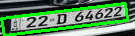

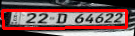

14_jpg.rf.aaa3db98a8f0e3c867c91b2ec427bc8c.jpg


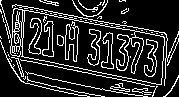

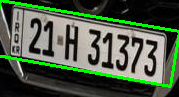

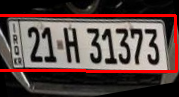

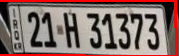

1_jpg.rf.e0d71bfac749526f7f57a7274f7f8f1e.jpg


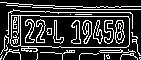

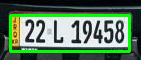

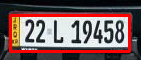

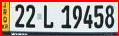

a-567-_JPG_jpg.rf.944dc3f4160c5d0eb41eaf414fe83c48.jpg


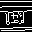

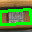

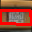

419241033_2209276712612167_308946357964497821_n_jpg.rf.d8c0ae777f53338fc56caa1c81550fb6.jpg


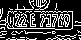

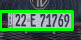

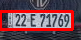

427667093_1133225274664600_1272288515667003555_n_jpg.rf.fe8ee31a87b81f2b3c76095f0dfec927.jpg


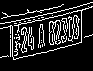

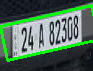

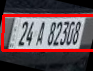

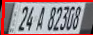

In [ ]:
import cv2
import numpy as np

def find_license_plate_min_area_rect(edge_image):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_contour = None
    largest_perimeter=0

    # Loop through all detected contours
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour,True)
        if perimeter >largest_perimeter:

            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            largest_contour = contour
            largest_area = area
            largest_perimeter=perimeter

    if largest_contour is not None:
        return box, rect

    else:
        raise ValueError("No suitable license plate contour detected.")

def rotate_and_crop(image, rect):
    width, height = int(rect[1][0]), int(rect[1][1])
    angle = rect[2]

    if width < height:
        width, height = height, width
        angle -= 90
    center = rect[0]

    # Compute the rotation matrix to align the rectangle horizontally
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the entire image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Calculate new bounding box coordinates in the rotated image
    x = int(center[0] - width / 2)
    y = int(center[1] - height / 2)

    # Clamp coordinates to be within image boundaries
    x = max(0, min(x, rotated_image.shape[1] - width))
    y = max(0, min(y, rotated_image.shape[0] - height))
    width = min(width, rotated_image.shape[1] - x)
    height = min(height, rotated_image.shape[0] - y)

    # Crop the aligned rectangle from the rotated image
    cropped_image = rotated_image[y:y + height, x:x + width]

    return cropped_image, rotated_image, rotation_matrix

def crop_and_save_license_plate(image_path, edge_image_path, save_path):
    image = cv2.imread(image_path)
    edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

    # Find the minimum area rectangle of the license plate
    box, rect = find_license_plate_min_area_rect(edge_image)

    # Rotate and crop the image based on the aligned rectangle
    cropped_image, rotated_image, rotation_matrix = rotate_and_crop(image, rect)

    # Save the cropped image
    cv2.imwrite(save_path, cropped_image)

    # Draw the bounding box on the original and rotated image for visualization
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

    # Apply the same rotation to the original box points for visualization
    box = np.int0(cv2.transform(np.array([box]), rotation_matrix)[0])
    cv2.drawContours(rotated_image, [box], 0, (0, 0, 255), 2)

    # Display the result
    cv2_imshow( image)
    cv2_imshow(rotated_image)
    cv2_imshow( cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
paths=os.listdir('/content/images')
for path in paths:
  print(path)
  path= '/content/images/'+path
  visualize_canny_edges(path)
  edge_image_path = '/content/canny_edges.png'  # Path to the edge-detected image
  original_image_path = path  # Path to the original image
  save_path = '/content/cropped.jpg'  # Path to save the cropped image

  # Crop and save the license plate with contour simplification
  crop_and_save_license_plate(original_image_path, edge_image_path, save_path)

# # Example usage
# edge_image_path = '/content/canny_edges.png'  # Path to the edge-detected image
# original_image_path = '/content/14_jpg.rf.aaa3db98a8f0e3c867c91b2ec427bc8c.jpg'  # Path to the original image
# save_path = '/content/cropped3.jpg'  # Path to save the cropped image

# # Load edge-detected image
# edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

# # Crop and save the license plate
# crop_and_save_license_plate(original_image_path, edge_image_path, save_path)

/content/images_resized/RESIZED_14_jpg.rf.f1c081d395119dc3a3b80a247afbffc1.jpg


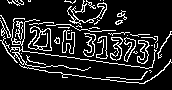

((95.33251190185547, 73.04196166992188), (23.126399993896484, 151.98292541503906), 88.10347747802734)


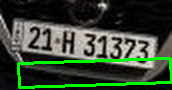

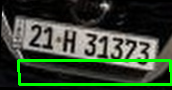

/content/images_resized/RESIZED_57_jpg.rf.4d70900ecf4c5af1e6db08e7fc1fc0152.jpg


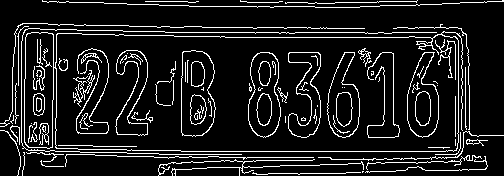

((256.5282287597656, 92.34869384765625), (403.21795654296875, 117.72178649902344), 0.15915453433990479)


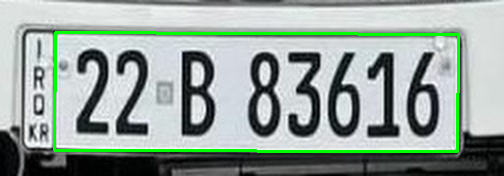

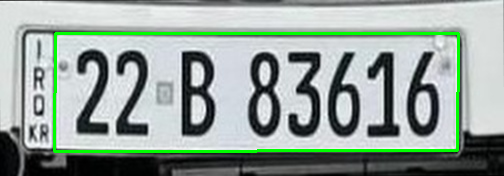

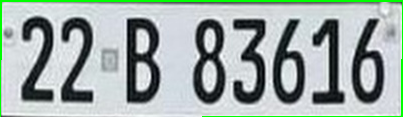

/content/images_resized/RESIZED_57_jpg.rf.4d70900ecf4c5af1e6db08e7fc1fc015.jpg


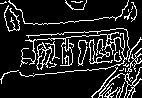

((131.8000030517578, 7.600000858306885), (0.6324555277824402, 3.1622774600982666), 18.43494987487793)


error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def visualize_canny_edges(image_path, low_threshold=20, high_threshold=180):
    # Load the image
    print(image_path)
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detector
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)

    # Display the original and edge-detected images side by side
    combined_image = np.hstack((gray_image, edges))

    # Add text labels to differentiate between original and edge-detected images
    cv2.putText(combined_image, 'Original', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(combined_image, 'Edges', (gray_image.shape[1] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the combined image
    cv2_imshow(edges)
    cv2.imwrite('canny_edges.png', edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()





def find_license_plate_min_area_rect_with_coverage(edge_image, min_coverage=0.75, max_iterations=10):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_area = 0
    largest_perimeter=0
    best_rect = None
    best_box = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
          original_length = len(contour)
          perimeter = cv2.arcLength(contour,True)
          area = cv2.contourArea(contour)
          if perimeter > largest_perimeter:
              original_length = len(contour)
              for i in range(max_iterations):
                  epsilon = i * cv2.arcLength(contour, True) / (max_iterations - 1)
                  approx_contour = cv2.approxPolyDP(contour, epsilon, True)
                  image1= cv2.imread(original_image_path)
                  cv2.drawContours(image1, approx_contour, -1, (0, 255, 0), 2)

                    # Display the original image with contours
                  # Check if the simplified contour covers at least the required percentage
                  if len(approx_contour) >= min_coverage * original_length:
                      rect = cv2.minAreaRect(approx_contour)
                      box = cv2.boxPoints(rect)
                      box = np.intp(box)

                      largest_area = area
                      largest_perimeter=perimeter
                      best_rect = rect
                      best_box = box
                      break

    if best_rect is not None:
        return best_box, best_rect
    else:
        raise ValueError("No suitable license plate contour detected.")

def rotate_and_crop(image, rect):
    width, height = int(rect[1][0]), int(rect[1][1])
    angle = rect[2]
    if width < height:
        width, height = height, width
        angle -= 90
    center = rect[0]

    # Compute the rotation matrix to align the rectangle horizontally
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the entire image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Calculate new bounding box coordinates in the rotated image
    x = int(center[0] - width / 2)
    y = int(center[1] - height / 2)

    # Clamp coordinates to be within image boundaries
    x = max(0, min(x, rotated_image.shape[1] - width))
    y = max(0, min(y, rotated_image.shape[0] - height))
    width = min(width, rotated_image.shape[1] - x)
    height = min(height, rotated_image.shape[0] - y)

    # Crop the aligned rectangle from the rotated image
    cropped_image = rotated_image[y:y + height, x:x + width]

    return cropped_image, rotated_image, rotation_matrix

def crop_and_save_license_plate_vertically(image_path, edge_image_path, save_path, min_coverage=0.75):
    image = cv2.imread(image_path)
    edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

    # Find the minimum area rectangle of the license plate with contour simplification
    box, rect = find_license_plate_min_area_rect_with_coverage(edge_image, min_coverage)
    print(rect)
    # Rotate and crop the image based on the aligned rectangle
    cropped_image, rotated_image, rotation_matrix = rotate_and_crop(image, rect)

    # Save the cropped image
    cv2.imwrite(save_path, cropped_image)

    # Draw the bounding box on the original and rotated image for visualization
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

    # Apply the same rotation to the original box points for visualization
    box = np.intp(cv2.transform(np.array([box]), rotation_matrix)[0])
    cv2.drawContours(rotated_image, [box], 0, (0, 255, 0), 2)

    # Display the result
    cv2_imshow(image)
    cv2_imshow(rotated_image)
    cv2_imshow(cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
# Example usage
# Example usage
paths=os.listdir('/content/images_resized')
for path in paths:
  path= '/content/images_resized/'+path
  visualize_canny_edges(path)
  edge_image_path = '/content/canny_edges.png'  # Path to the edge-detected image
  original_image_path = path  # Path to the original image
  save_path = '/content/cropped.jpg'  # Path to save the cropped image

  # Crop and save the license plate with contour simplification
  crop_and_save_license_plate_vertically(original_image_path, edge_image_path, save_path, min_coverage=0.75)


# Macathon Code

In [ ]:
import cv2
import itertools, os, time
import numpy as np
import argparse
import pandas as pd
import operator
import os

In [ ]:
def label_to_en(label):
    new = ""
    for l in label:
        if l == " ":
            continue
        elif l in string.digits:
            new += l
        else:
            try:
                new = new + ar_to_en[l]
            except:
                continue

    missing = max_letters - len(new)
    if missing > 0:
        new = new + "X" * missing
    return new

# Function to reverse a string
def reverse_str(s):
    return s[::-1]

# Function to convert label to Arabic
def label_to_ar(label):
    label = reverse_str(label)
    ar_label = ""
    for i in label:
        if i == "X":
            continue
        else:
            ar_label += en_to_ar[i] + " "
    ar_label = ar_label.strip()
    return ar_label

# Function to get label from indexes
def get_label(idxes):
    label = ""
    for idx in idxes:
        if idx < len(letters):
            label += letters[idx]
    return label

# Function to decode label
def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))
    out_best = [k for k, g in itertools.groupby(out_best)]
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Reshape, Lambda
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import add, concatenate


# VGG Blocks
class VggBlock1(keras.layers.Layer):
    def __init__(self, num_filters, do_maxpool: bool = True, **kwargs):
        super(VggBlock1, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.do_maxpool = do_maxpool
        self.conv = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn = BatchNormalization()
        self.relu = Activation("relu")
        if self.do_maxpool:
            self.pool = MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        if self.do_maxpool:
            x = self.pool(x)
        return x

    def get_config(self):
        config = super(VggBlock1, self).get_config()
        config.update({
            'num_filters': self.num_filters,
            'do_maxpool': self.do_maxpool
        })
        return config


class VggBlock2(keras.layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super(VggBlock2, self).__init__(**kwargs)
        self.num_filters = num_filters

        self.conv1 = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn1 = BatchNormalization()
        self.relu1 = Activation("relu")
        self.conv2 = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn2 = BatchNormalization()
        self.relu2 = Activation("relu")
        self.pool = MaxPooling2D(pool_size=(1, 2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        return x

    def get_config(self):
        config = super(VggBlock2, self).get_config()
        config.update({"num_filters": self.num_filters})
        return config



# RNN
class BI_LSTM_Block(keras.layers.Layer):
    def __init__(self, num_units, merge_mode, **kwargs):
        super(BI_LSTM_Block, self).__init__(**kwargs)
        self.num_units = num_units
        self.merge_mode = merge_mode

        self.bi_lstm = Bidirectional(
            LSTM(num_units, return_sequences=True, kernel_initializer="he_normal"),
            merge_mode=merge_mode,
        )
        self.bn = BatchNormalization()

    def call(self, inputs):
        x = self.bi_lstm(inputs)
        x = self.bn(x)
        return x

    def get_config(self):
        config = super(BI_LSTM_Block, self).get_config()
        config.update({"num_units": self.num_units, "merge_mode": self.merge_mode})
        return config



def ctc_lamda_func(args):
    y_pred, labels, input_length, label_length = args

    y_pred = y_pred[:, 2:, :]
    return keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


def build_model(training):

    input_shape = (128, 64, 1)

    inputs = Input(name="the_input", shape=input_shape, dtype="float32")

    # VGG (CNN)
    x = VggBlock1(64, name="VGG_Block1")(inputs)
    x = VggBlock1(128, name="VGG_Block2")(x)
    x = VggBlock2(256, name="VGG_Block3")(x)
    x = VggBlock2(512, name="VGG_Block4")(x)
    x = VggBlock1(512, do_maxpool=False, name="VGG_Block5")(x)

    # CNN to RNN
    new_shape = (32, 2048)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", kernel_initializer="he_normal", name="dense1")(x)

    # RNN
    x = BI_LSTM_Block(256, merge_mode="sum", name="BI_LSTM_Block1")(x)
    x = BI_LSTM_Block(128, merge_mode="concat", name="BI_LSTM_Block2")(x)

    x = Dropout(0.25)(x)

    # RNN output to character activations
    x = Dense(num_classes, kernel_initializer="he_normal", name="dense2")(x)
    y_pred = Activation("softmax", name="softmax")(x)

    labels = Input(name="the_labels", shape=[max_text_len], dtype="float32")
    input_length = Input(name="input_length", shape=[1], dtype="int64")
    label_length = Input(name="label_length", shape=[1], dtype="int64")

    loss_out = Lambda(ctc_lamda_func, output_shape=(1,), name="ctc")(
        [y_pred, labels, input_length, label_length]
    )

    if training:
        return keras.Model(
            inputs=[inputs, labels, input_length, label_length], outputs=loss_out
        )
    else:
        return keras.Model(inputs=[inputs], outputs=y_pred)

In [ ]:
import string

# Original mapping from class_name to English letters
original_mapping = {
    "1": "1", "6": "6", "5": "5", "4": "4", "7": "7", "9": "9", "3": "3", "2": "2", "8": "8",
    "meem": "م", "0": "0", "raa": "ر", "seen": "س", "alif": "ا", "daal": "د", "noon": "ن",
    "waw": "و", "ain": "ع", "haa": "ه", "laam": "ل", "jeem": "ج", "baa": "ب", "qaaf": "ق",
    "yaa": "ى", "faa": "ف", "Taa": "ط", "saad": "ص", "thaa": "ث", "ghayn": "ج", "sheen": "ش",
    "Thaa": "ظ", "khaa": "خ", "kaaf": "ك", "taa": "ت", "zay": "ز", "zaal": "ذ", "7aa": "ح",
    "daad": "ض"
}

# Arabic to English mapping
ar_to_en = {
    "١": "1", "٢": "2", "٣": "3", "٤": "4", "٥": "5", "٦": "6", "٧": "7", "٨": "8", "٩": "9", "٠": "0",
    "ا": "A", "ب": "B", "ت": "C", "ث": "D", "ج": "E", "ح": "F", "خ": "G", "د": "H", "ذ": "I",
    "ر": "J", "ز": "K", "س": "L", "ش": "M", "ص": "N", "ض": "O", "ط": "P", "ظ": "Q", "ع": "R", "غ": "S",
    "ف": "T", "ق": "U", "ك": "V", "ل": "W", "م": "n", "ن": "Y", "ه": "Z", "و": "a", "ى": "b",
    "1": "1", "2": "2", "3": "3", "4": "4", "5": "5", "6": "6", "7": "7", "8": "8", "9": "9", "0": "0"
}

en_to_ar = {v: k for k, v in ar_to_en.items()}

# Remove duplicate values to get unique letters
unique_letters = sorted(set(ar_to_en.values()))

# Add 'X' as the padding character
unique_letters.append('X')

# Convert the unique letters list to a string
CHAR_VECTOR = ''.join(unique_letters)

# Create a list of letters
letters = [letter for letter in CHAR_VECTOR]

num_classes = len(letters) + 1

In [ ]:
max_text_len = 17

In [ ]:
import os
import pandas as pd

def predict_and_submit(model, test_images_folder, output_csv_file):
    predictions_df = pd.DataFrame(columns=['img_name', 'label'])

    start = time.time()
    for img_name in os.listdir(test_images_folder):
        img_path = os.path.join(test_images_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img_pred = img.astype(np.float32)
        img_pred = cv2.resize(img_pred, (128, 64))
        img_pred = (img_pred / 255.0)
        img_pred = img_pred.T
        img_pred = np.expand_dims(img_pred, axis=-1)
        img_pred = np.expand_dims(img_pred, axis=0)

        net_out_value = model.predict(img_pred, verbose=1)
        pred_text = decode_label(net_out_value)
        pred_text_ar = label_to_ar(pred_text)

        # Assuming 'img_name' and 'label' are columns in your DataFrame
        new_row = {'img_name': img_name, 'label': ''.join(pred_text_ar).replace(" ", "")}
        predictions_df = pd.concat([predictions_df, pd.DataFrame([new_row])], ignore_index=True)


        print(f"Predicted label for {img_name}: {pred_text_ar}")

    predictions_df.to_csv(output_csv_file, index=False)

    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")


# Get RCNN model
model = build_model(False)
try:
        model.load_weights("/content/model_ad_best.keras")
        print("...Previous weight data...")
except:
        raise Exception("No weight file!")
test_images_folder = "/content/test_images"
output_csv_file = "/content/submission.csv"

predict_and_submit(model, test_images_folder, output_csv_file)

...Previous weight data...
1/1 [==============================] - 2s 2s/step
Predicted label for iraq.png: و ا ن 9 9 8
1/1 [==============================] - 0s 184ms/step
Predicted label for bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg: ب 1 1
1/1 [==============================] - 0s 187ms/step
Predicted label for Picture1.jpg: ه ف ر د 0 4
1/1 [==============================] - 0s 171ms/step
Predicted label for WhatsApp-Image-2024-01-28-at-04-41-05_fd4debcb_jpg.rf.e830b7f4f8118db677a22a48b2f68fa8.jpg: ص 8 8 8 1


AttributeError: 'NoneType' object has no attribute 'astype'

# Fun

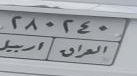

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load the image
image = cv2.imread("/content/bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter and find the contour of the license plate
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:
        # Draw the contour on the original image
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
        # Print corner points
        print("Corner points: ", approx)
        break

# Display the result
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


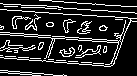

In [ ]:
import cv2
import numpy as np

def visualize_canny_edges(image_path, low_threshold=50, high_threshold=150):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detector
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)

    # Display the original and edge-detected images side by side
    combined_image = np.hstack((gray_image, edges))

    # Add text labels to differentiate between original and edge-detected images
    cv2.putText(combined_image, 'Original', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(combined_image, 'Edges', (gray_image.shape[1] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the combined image
    cv2_imshow(edges)
    cv2.imwrite('canny_edges.png', edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = '/content/bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg'  # Replace with your image path
visualize_canny_edges(image_path)


<ipython-input-150-712f7a3686bc>:16: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-150-712f7a3686bc>:71: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.transform(np.array([box]), rotation_matrix)[0])


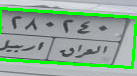

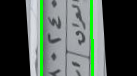

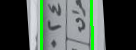

In [ ]:
import cv2
import numpy as np

def find_license_plate_min_area_rect(edge_image):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    largest_contour = None

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            largest_contour = contour
            largest_area = area

    if largest_contour is not None:
        return box, rect
    else:
        raise ValueError("No suitable license plate contour detected.")

def rotate_and_crop(image, rect):
    width, height = int(rect[1][0]), int(rect[1][1])
    angle = rect[2]
    # angle=90-angle
    # print(angle)
    # angle=90-angle
    center = rect[0]

    # Compute the rotation matrix to align the rectangle horizontally
    rotation_matrix = cv2.getRotationMatrix2D(center, angle+90, 1.0)

    # Rotate the entire image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Calculate new bounding box coordinates in the rotated image
    x = int(center[0] - width / 2)
    y = int(center[1] - height / 2)

    # Clamp coordinates to be within image boundaries
    x = max(0, min(x, rotated_image.shape[1] - width))
    y = max(0, min(y, rotated_image.shape[0] - height))
    width = min(width, rotated_image.shape[1] - x)
    height = min(height, rotated_image.shape[0] - y)

    # Crop the aligned rectangle from the rotated image
    cropped_image = rotated_image[y:y + height, x:x + width]

    return cropped_image, rotated_image, rotation_matrix

def crop_and_save_license_plate(image_path, edge_image_path, save_path):
    image = cv2.imread(image_path)
    edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

    # Find the minimum area rectangle of the license plate
    box, rect = find_license_plate_min_area_rect(edge_image)

    # Rotate and crop the image based on the aligned rectangle
    cropped_image, rotated_image, rotation_matrix = rotate_and_crop(image, rect)

    # Save the cropped image
    cv2.imwrite(save_path, cropped_image)

    # Draw the bounding box on the original and rotated image for visualization
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

    # Apply the same rotation to the original box points for visualization
    box = np.int0(cv2.transform(np.array([box]), rotation_matrix)[0])
    cv2.drawContours(rotated_image, [box], 0, (0, 255, 0), 2)

    # Display the result
    cv2_imshow( image)
    cv2_imshow(rotated_image)
    cv2_imshow( cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Example usage
edge_image_path = '/content/canny_edges.png'  # Path to the edge-detected image
original_image_path = '/content/bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg'  # Path to the original image
save_path = '/content/cropped3.jpg'  # Path to save the cropped image

# Load edge-detected image
edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

# Crop and save the license plate
crop_and_save_license_plate(original_image_path, edge_image_path, save_path)

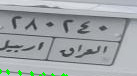

<ipython-input-153-3ccdc2ffd98e>:26: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


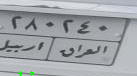

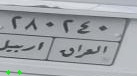

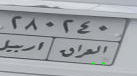

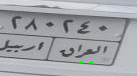

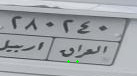

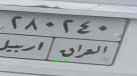

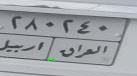

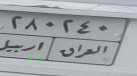

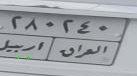

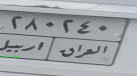

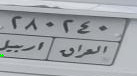

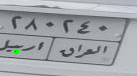

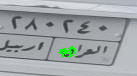

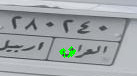

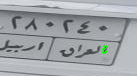

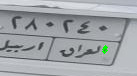

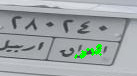

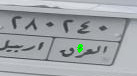

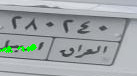

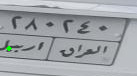

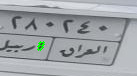

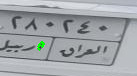

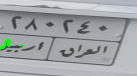

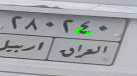

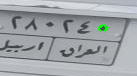

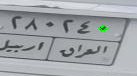

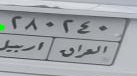

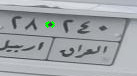

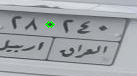

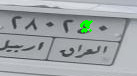

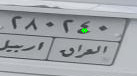

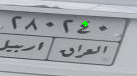

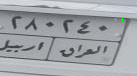

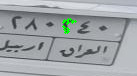

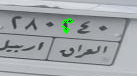

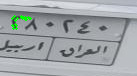

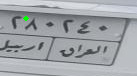

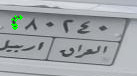

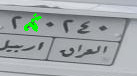

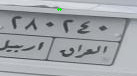

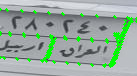

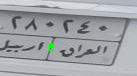

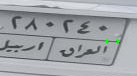

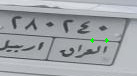

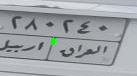

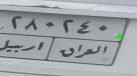

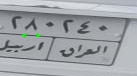

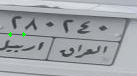

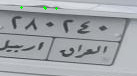

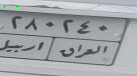

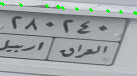

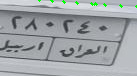

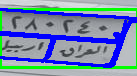

In [ ]:
import cv2
import numpy as np

def find_license_plate_box(edge_image):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to hold the largest contour
    largest_contour = None
    largest_area = 0

    # Loop through all detected contours
    for contour in contours:
        # Calculate the area of the contour
        image = cv2.imread('/content/bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg')
        cv2.drawContours(image, contour, -1, (0, 255, 0), 2)

        # Display the original image with contours
        cv2_imshow(image)
        area = cv2.contourArea(contour)

        # Consider contours that are reasonably large and have four corners
        if area > 0.9*largest_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            largest_contour = contour
            largest_area = area

    # Check if a contour was found
    if largest_contour is not None:

        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h), largest_contour
    else:
        raise ValueError("No suitable license plate contour detected.")

def visualize_license_plate_box(image_path, edge_image):
    # Load the original image
    image = cv2.imread(image_path)

    # Find the bounding box of the license plate
    bounding_box, contour = find_license_plate_box(edge_image)
    x, y, w, h = bounding_box

    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Draw the contour
    cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)

    # Display the result
    cv2_imshow( image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
edge_image_path = '/content/canny_edges.png'  # Replace with the path to your edge-detected image
image_path = '/content/bz55_jpg.rf.530decdda9e06c7af61f364545a894ed.jpg'  # Replace with the path to your original image

# Load edge-detected image
edge_image = cv2.imread(edge_image_path, cv2.IMREAD_GRAYSCALE)

visualize_license_plate_box(image_path, edge_image)
